Using MNIST dataset

In [ ]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('Train', x_train.shape, y_train.shape)
print('Test', x_test.shape, y_test.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


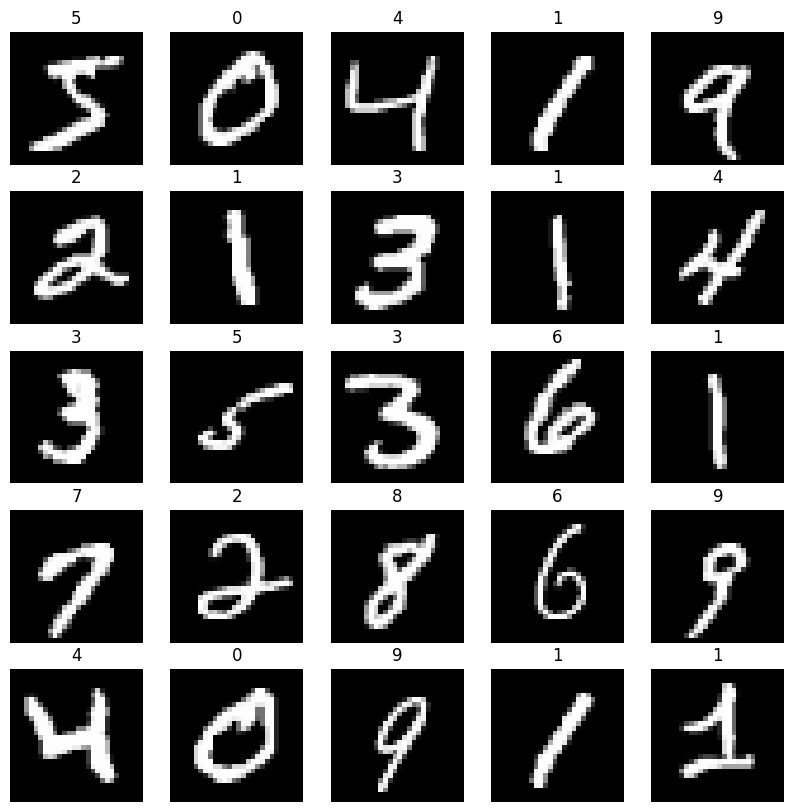

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[i], cmap='Greys_r')
    plt.title(y_train[i])
    plt.axis('off')

plt.show()

In [ ]:
# one-hot encode the data lables
from tensorflow import keras

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [ ]:
# break training set into training and validation sets
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

In [ ]:
y_test.shape

(10000, 10)

In [ ]:
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout  # Import CNN and Dense layers
from keras.models import Sequential  # Import Sequential model container


def model_builder():
    """
    Builds and compiles a simple Convolutional Neural Network using Keras Sequential API.
    Architecture:
      1. Conv2D + MaxPooling2D (Block 1)
      2. Conv2D + MaxPooling2D + Dropout (Block 2)
      3. Flatten + Dense (Fully connected head)
    """
    # 1) Instantiate a Sequential model
    model = Sequential()

    # 2) Block 1: Convolution followed by pooling
    model.add(
        Conv2D(
            filters=64,              # Number of convolution filters
            kernel_size=(3, 3),      # Filter size: 3x3
            activation='relu',        # Activation function: ReLU
            padding='same',           # Same padding: output size matches input spatial dimensions
            input_shape=(28, 28, 1)   # Input shape: 28x28 grayscale images
        )
    )
    model.add(
        MaxPooling2D(
            pool_size=(2, 2)         # Downsample by taking max over 2x2 windows
        )
    )
    # Optional: Dropout to reduce overfitting
    # model.add(Dropout(0.25))           # Uncomment to drop 25% of activations during training

    # 3) Block 2: Another conv-pool block with dropout
    model.add(
        Conv2D(
            filters=128,             # 128 filters this time
            kernel_size=(3, 3),
            activation='relu'
        )
    )
    model.add(
        MaxPooling2D(
            pool_size=(2, 2)
        )
    )
    model.add(
        Dropout(
            rate=0.25               # Drop 25% of activations to prevent overfitting
        )
    )

    # 4) Flatten the feature maps to feed into Dense layers
    model.add(Flatten())            # Convert HxWxC feature map into 1D vector

    # 5) Fully Connected (Dense) layers
    model.add(
        Dense(
            units=128,             # Number of neurons in the dense layer
            activation='relu',      # ReLU activation for non-linearity
            kernel_initializer='he_uniform'  # He uniform initializer for weights
        )
    )
    model.add(
        Dense(
            units=10,              # 10 output classes (e.g., digits 0-9)
            activation='softmax'    # Softmax for probability distribution over classes
        )
    )

    # 6) Print the model summary to see layer details
    model.summary()

    # 7) Compile the model: specify optimizer, loss function, and evaluation metric
    model.compile(
        optimizer='Adam',                 # Adam optimizer with default learning rate
        loss='categorical_crossentropy',  # Loss function for multi-class one-hot targets
        metrics=['accuracy']              # Track accuracy during training and evaluation
    )

    return model


model = model_builder()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 665,738 (2.54 MB)

 Trainable params: 665,738 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

# **Training**

In [66]:
import tensorflow as tf

# === Hyperparameters ===
NUM_EPOCHS  = 20   # Total number of training epochs
BATCH_SIZE  = 32   # Number of samples per gradient update
VALID_SPLIT = 0.2  # Fraction of training data used for validation
PATIENCE    = 5    # Number of epochs with no improvement before early stopping

# === Callbacks ===
callbacks = [
    # Stops training when 'val_accuracy' has not improved for 'PATIENCE' epochs
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=PATIENCE,
        restore_best_weights=True  # After stopping, restore model weights from best epoch
    ),
    # Saves the model after every epoch if 'val_accuracy' improves
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.keras',  # Use native Keras format (.keras)
        monitor='val_accuracy',
        save_best_only=True,          # Only keep the checkpoint with highest 'val_accuracy'
    )
]

# === Model Training ===
history = model.fit(
    x=x_train,                # Training input data
    y=y_train,                # Training target labels
    epochs=NUM_EPOCHS,        # Maximum number of epochs to train
    batch_size=BATCH_SIZE,    # Number of samples per batch
    validation_split=VALID_SPLIT,  # Portion of data reserved for validation
    callbacks=callbacks,      # List of callback functions to apply during training
    verbose=2                 # Verbosity mode: 0=silent, 1=progress bar, 2=one line per epoch
)

Epoch 1/20
1375/1375 - 120s - 88ms/step - accuracy: 0.9911 - loss: 0.0314 - val_accuracy: 0.9875 - val_loss: 0.0524
Epoch 2/20
1375/1375 - 140s - 102ms/step - accuracy: 0.9922 - loss: 0.0288 - val_accuracy: 0.9849 - val_loss: 0.0656
Epoch 3/20
1375/1375 - 119s - 86ms/step - accuracy: 0.9928 - loss: 0.0248 - val_accuracy: 0.9874 - val_loss: 0.0580
Epoch 4/20
1375/1375 - 143s - 104ms/step - accuracy: 0.9934 - loss: 0.0229 - val_accuracy: 0.9891 - val_loss: 0.0639
Epoch 5/20
1375/1375 - 117s - 85ms/step - accuracy: 0.9929 - loss: 0.0257 - val_accuracy: 0.9841 - val_loss: 0.0894
Epoch 6/20
1375/1375 - 146s - 106ms/step - accuracy: 0.9939 - loss: 0.0224 - val_accuracy: 0.9889 - val_loss: 0.0609
Epoch 7/20
1375/1375 - 141s - 103ms/step - accuracy: 0.9933 - loss: 0.0251 - val_accuracy: 0.9892 - val_loss: 0.0565
Epoch 8/20
1375/1375 - 142s - 103ms/step - accuracy: 0.9942 - loss: 0.0213 - val_accuracy: 0.9877 - val_loss: 0.0842
Epoch 9/20
1375/1375 - 141s - 103ms/step - accuracy: 0.9948 - loss:

## **Evaluation**

In [67]:
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {acc * 100:.2f}%")

Test accuracy: 98.94%


# **Implementing a CNN model using TensorFlow**

In [68]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

In [69]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Reshape it so the Conv layers knows its scale

In [70]:
train_images = train_images.reshape(-1, 28, 28, 1).astype('float32') / 255.0
test_images = test_images.reshape(-1, 28, 28, 1).astype('float32') / 255.0

In [71]:
train_labels = tf.one_hot(train_labels, depth=10)
test_labels = tf.one_hot(test_labels, depth=10)

# **Define the CNN model using TF**

In [72]:
import tensorflow as tf

class CNNModel(tf.Module):
    def __init__(self):
        # --- Layer parameter initialization ---
        # conv1_w: 3×3 filters, 1 input channel (e.g. grayscale), 32 output feature maps
        self.conv1_w = tf.Variable(
            tf.random.truncated_normal([3, 3, 1, 32], stddev=0.1),
            name="conv1_weights"
        )
        # conv1_b: one bias per output channel
        self.conv1_b = tf.Variable(tf.zeros([32]), name="conv1_biases")

        # conv2_w: 3×2 filters, 32 input channels, 64 output feature maps
        self.conv2_w = tf.Variable(
            tf.random.truncated_normal([3, 2, 32, 64], stddev=0.1),
            name="conv2_weights"
        )
        self.conv2_b = tf.Variable(tf.zeros([64]), name="conv2_biases")

        # fc1_w: fully‑connected layer weights.
        # Input size is 7×7×64 (after two 2×2 max‑pools on a 28×28 image),
        # output size is 128 hidden units
        self.fc1_w = tf.Variable(
            tf.random.truncated_normal([7 * 7 * 64, 128], stddev=0.1),
            name="fc1_weights"
        )
        self.fc1_b = tf.Variable(tf.zeros([128]), name="fc1_biases")

        # fc2_w: final layer weights mapping 128 units to 10 classes
        self.fc2_w = tf.Variable(
            tf.random.truncated_normal([128, 10], stddev=0.1),
            name="fc2_weights"
        )
        self.fc2_b = tf.Variable(tf.zeros([10]), name="fc2_biases")


    def __call__(self, x, training=False):
        # --- Forward pass ---

        # 1) First convolution: stride 1, same padding → preserves spatial dims (28×28)
        x = tf.nn.conv2d(x, self.conv1_w, strides=[1, 1, 1, 1], padding='SAME')
        x = x + self.conv1_b                                # add bias
        x = tf.nn.relu(x)                                   # apply ReLU nonlinearity
        # Max‑pool 2×2, stride 2 → halves spatial dims to (14×14)
        x = tf.nn.max_pool2d(x, ksize=[1, 2, 2, 1],
                              strides=[1, 2, 2, 1], padding='SAME')

        # 2) Second convolution: same pattern but more channels
        x = tf.nn.conv2d(x, self.conv2_w, strides=[1, 1, 1, 1], padding='SAME')
        x = x + self.conv2_b
        x = tf.nn.relu(x)
        # Another 2×2 max‑pool → dims now (7×7)
        x = tf.nn.max_pool2d(x, ksize=[1, 2, 2, 1],
                              strides=[1, 2, 2, 1], padding='SAME')

        # 3) Flatten the tensor to [batch_size, 7*7*64] for the dense layers
        x = tf.reshape(x, [-1, 7 * 7 * 64])

        # 4) First fully connected (dense) layer
        x = tf.matmul(x, self.fc1_w) + self.fc1_b
        x = tf.nn.relu(x)                                   # apply ReLU

        # 5) Dropout only during training to reduce overfitting
        if training:
            x = tf.nn.dropout(x, rate=0.5)

        # 6) Output logits (unnormalized scores) for each of the 10 classes
        logits = tf.matmul(x, self.fc2_w) + self.fc2_b

        return logits

In [73]:
def loss_fn(logits, labels):
    """
    Computes the mean softmax cross‐entropy loss between predictions and true labels.

    Args:
        logits:   A [batch_size, num_classes] tensor of raw model outputs.
        labels:   A [batch_size, num_classes] one‐hot encoded tensor of true classes.

    Returns:
        A scalar Tensor: the average cross‐entropy loss over the batch.
    """
    # tf.nn.softmax_cross_entropy_with_logits:
    #   - Applies softmax to logits
    #   - Computes cross‐entropy against the provided one‐hot labels
    # Returns a [batch_size] tensor of per‐example losses.
    per_example_loss = tf.nn.softmax_cross_entropy_with_logits(
        logits=logits,
        labels=labels
    )
    # tf.reduce_mean: average the per‐example losses into a single scalar
    return tf.reduce_mean(per_example_loss)


def accuracy_fn(logits, labels):
    """
    Computes classification accuracy by comparing predicted vs. true labels.

    Args:
        logits:   A [batch_size, num_classes] tensor of raw model outputs.
        labels:   A [batch_size, num_classes] one‐hot encoded tensor of true classes.

    Returns:
        A scalar Tensor: the fraction of examples the model classified correctly.
    """
    # tf.argmax(logits, axis=1): index of highest logit = predicted class
    # tf.argmax(labels, axis=1): index of the true class in one‐hot labels
    predicted_classes = tf.argmax(logits, axis=1)
    true_classes      = tf.argmax(labels, axis=1)

    # tf.equal returns a [batch_size] boolean tensor: True where prediction matches label
    correct_pred = tf.equal(predicted_classes, true_classes)

    # tf.cast converts booleans to floats (True→1.0, False→0.0)
    # tf.reduce_mean then computes the average, i.e., accuracy over the batch
    return tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [74]:
@tf.function
def train_step(model, images, labels, optimizer):
    # Track operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Forward pass (dropout enabled during training)
        logits = model(images, training=True)
        # Compute batch loss
        loss = loss_fn(logits, labels)

    # Compute gradients of loss w.r.t. model parameters
    gradients = tape.gradient(loss, model.trainable_variables)
    # Update parameters using computed gradients
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Return loss for logging/monitoring
    return loss


In [75]:
# Create the model and optimizer
model = CNNModel()
optimizer = tf.optimizers.Adam()

In [76]:
# --- Training configuration ---
EPOCHS = 5           # Number of times to iterate over the full training set
BATCH_SIZE = 64      # Number of samples per gradient update

for epoch in range(EPOCHS):
    # 1) Prepare the training dataset: slice tensors and batch them
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    train_ds = train_ds.batch(BATCH_SIZE)

    # 2) Training loop: run a train_step on each batch
    for batch_images, batch_labels in train_ds:
        loss = train_step(model, batch_images, batch_labels, optimizer)

    # 3) After finishing all batches, evaluate performance on train & test sets

    # 3a) Recreate batched datasets for metric calculation
    train_eval_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(BATCH_SIZE)
    test_eval_ds  = tf.data.Dataset.from_tensor_slices((test_images,  test_labels)).batch(BATCH_SIZE)

    # 3b) Initialize accuracy metrics
    train_acc = tf.keras.metrics.CategoricalAccuracy()
    test_acc  = tf.keras.metrics.CategoricalAccuracy()

    # 3c) Compute training accuracy (no dropout, training=False)
    for batch_images, batch_labels in train_eval_ds:
        logits = model(batch_images, training=False)
        train_acc.update_state(batch_labels, logits)

    # 3d) Compute test accuracy similarly
    for batch_images, batch_labels in test_eval_ds:
        logits = model(batch_images, training=False)
        test_acc.update_state(batch_labels, logits)

    # 4) Log epoch summary
    print(
        f"Epoch {epoch+1}, "
        f"Loss: {loss.numpy():.4f}, "
        f"Train Accuracy: {train_acc.result().numpy():.4f}, "
        f"Test Accuracy: {test_acc.result().numpy():.4f}"
    )

Epoch 1, Loss: 0.0155, Train Accuracy: 0.9782, Test Accuracy: 0.9790
Epoch 2, Loss: 0.0034, Train Accuracy: 0.9879, Test Accuracy: 0.9865
Epoch 3, Loss: 0.0087, Train Accuracy: 0.9912, Test Accuracy: 0.9873
Epoch 4, Loss: 0.0396, Train Accuracy: 0.9937, Test Accuracy: 0.9895
Epoch 5, Loss: 0.0018, Train Accuracy: 0.9939, Test Accuracy: 0.9907


In [77]:
# Final test evaluation
final_test_logits = model(test_images, training=False)
final_test_acc = accuracy_fn(final_test_logits, test_labels)
print(f"Final Test Accuracy: {final_test_acc.numpy()}")

Final Test Accuracy: 0.9907000064849854
